# Case Study: Data Preprocessing (Keras & PyTorch)

In the first assignment of this course, you will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). In this notebook, you'll get a chance to explore this dataset and familiarize yourself with some of the techniques you'll use in the first graded assignment.

<img src="images/xray-image.png" alt="U-net Image" width="300" align="middle"/>

The first step before jumping into writing code for any machine learning project is to explore your data. A standard Python package for analyzing and manipulating data is [pandas](https://pandas.pydata.org/docs/#).

With the next two code cells, you'll import `pandas` and a package called `numpy` for numerical manipulation, then use `pandas` to read a csv file into a dataframe and print out the first few rows of data.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import seaborn as sns

# %matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

### Exploration

<img src="images/diseases.png">

In [2]:
train_df = pd.read_csv('data/train-small.csv')

# show first 5 rows
print(f'There are {train_df.shape[0]} rows & {train_df.shape[1]} columns')
train_df.head(3)

There are 1000 rows & 16 columns


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0


In order to understand what to do with data, we need to investigate the columns thoroughly. Let's first find out which diseases are present and their occurrences.

We see that there are several types of occurrences of fluids in lungs, therefore, we need to how many rows contain singular and multiple diseases.

In [3]:
# check unique diseases
columns = train_df.columns.tolist()

# drop irrelevant values
columns.remove('Image')
columns.remove('PatientId')

# show unique diseases
print(columns)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


In [5]:
# check the number of missing values
print(train_df.isna().sum())

# check the dataset
train_df.info()

Image                 0
Atelectasis           0
Cardiomegaly          0
Consolidation         0
Edema                 0
Effusion              0
Emphysema             0
Fibrosis              0
Hernia                0
Infiltration          0
Mass                  0
Nodule                0
PatientId             0
Pleural_Thickening    0
Pneumonia             0
Pneumothorax          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia      

In [6]:
def get_name(series):
    name = series[series == 1]
    if len(name) == 0:
        return 'Normal'
    return ', '.join(name.index)

# count instances
normal_ids, normal_count = [], 0
multi_ids, multi_count = [], 0

# iterate the dataframe
for idx, content in train_df.iterrows():
    col = get_name(content)

    if col == 'Normal':
        normal_count += 1
        normal_ids.append(idx)
    else:
        multi_count += 1
        multi_ids.append(idx)

print(f'Number of Normal Lungs: {normal_count}')
print(f'Number of Lungs with multiple diseases: {multi_count}')

Number of Normal Lungs: 562
Number of Lungs with multiple diseases: 438


### Unique ID check

"PatientId" has an identification number for each patient. One thing you'd like to know about a medical dataset like this is if you're looking at repeated data for certain patients or whether each image represents a different person.

In [7]:
print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

The total patient ids are 1000, from those the unique ids are 928 


As you can see, the number of unique patients in the dataset is less than the total number so there must be some overlap. For patients with multiple records, you'll want to make sure they do not show up in both training and test sets in order to avoid data leakage (covered later in this week's lectures).

### Data Visualization

Using the image names listed in the csv file, you can retrieve the image associated with each row of data in your dataframe.

Run the cell below to visualize a random selection of images from the dataset.

Display Random Images


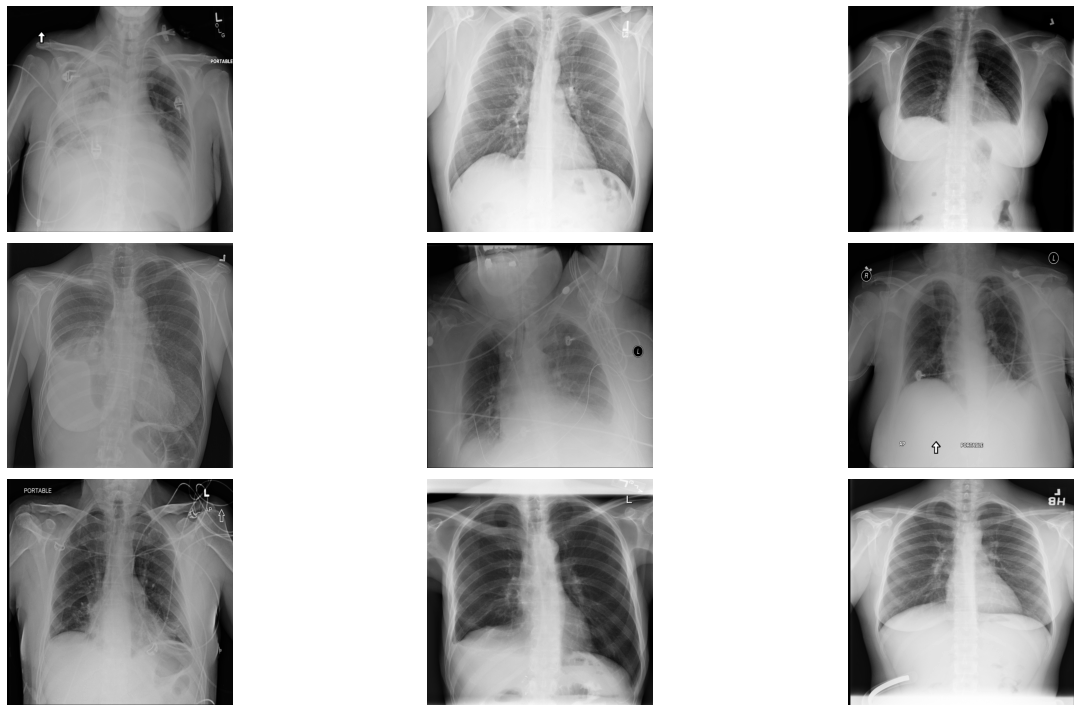

In [8]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'data/images-small/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    name = train_df[train_df['Image'] == random_images[i]]
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()

### Investigate single image

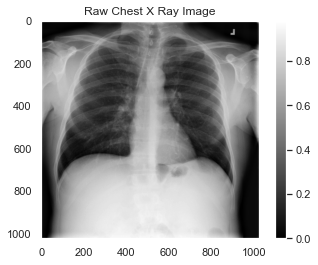

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


In [9]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))

# display image
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
plt.grid(False)
plt.show()

# display info
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate Pixel Value Distribution

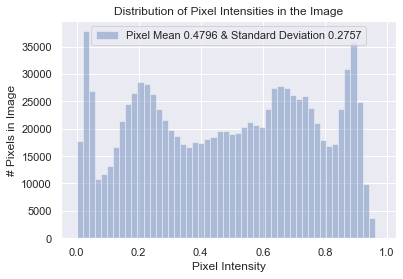

In [10]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(),
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()